## C S 329E HW 10

# Clustering with DBSCAN

## Adrian Garcia and Michael Walters - Group 69

As we discussed in lecture DBSCAN creates clusters based on the density of the points in the vicinity of the data.  Using small example data sets, we will implement both algorithms and visualize the results.

Even though the example data is small and 2 dimensional, write your helper functions to not assume a 2-D data set.  Your plotting code can reference the `x` and `y` column names from the sample data directly. 

Note that I have added a one or two lines of code to the questions to test your implementations. 

In [1]:
# Do not import anything else
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN # only on last problem

# DBSCAN

## Q1 Load the Density Data and try K-means

Load in the data provided `data_dbscan.csv`, cluster it with k-means algorithm with $k=2$ and visualize the results with a scatter plot, where the color indicates cluster membership. Label your axes, and give the plot a title. Use the [scikit-learn implementation of K-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

Text(0, 0.5, 'y')

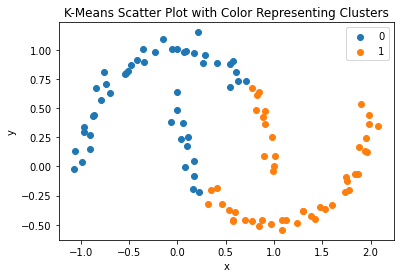

In [2]:
df_dbscan = pd.read_csv('https://gist.githubusercontent.com/yanyanzheng96/c4bf88d73e03305cc0e1abd0a8a8e185/raw/c15f0f59d06ccbe9e708eddaf361cc33c19b1ec6/data_dbscan.csv')

model = KMeans(n_clusters=2)
model.fit(df_dbscan)
model.labels_
for label in np.unique(model.labels_):
    plt.scatter(df_dbscan["x"][model.labels_ == label], df_dbscan["y"][model.labels_ == label], label=str(label))
plt.legend()
plt.title("K-Means Scatter Plot with Color Representing Clusters")
plt.xlabel("x")
plt.ylabel("y")

## Q2.2 Write function to Implement Range Query

Using the [pseudo-code](https://en.wikipedia.org/wiki/DBSCAN#Algorithm) on wikipedia, implement RangeQuery.

```
RangeQuery(DB, distFunc, Q, eps) {
    Neighbors N := empty list
    for each point P in database DB {                      /* Scan all points in the database */
        if distFunc(Q, P) ≤ eps then {                     /* Compute distance and check epsilon */
            N := N ∪ {P}                                   /* Add to result */
        }
    }
    return N
}
```

The "DB" parameter is a data frame, `df_data` containing all of the points in our data set, the "distFunc" is set as Euclidean distance thus should not be passed in, the point "Q", is represented by the index of the data frame, `q_index`, where `df_data.iloc[q_index]` is the actual point, and `eps` is a floating point value that indicates the radius from the point "Q" to search for neighbors.  The function will return the slice of `df_data` of all points within `eps` distance of "Q" (including "Q").  The indices on the slice should be preserved (do not reset_index).  

In [3]:
def range_query( df_data, q_index, eps ):
    q = df_data.iloc[q_index]
    dist = np.linalg.norm(df_data - q, axis=1)
    return df_data[dist <= eps]

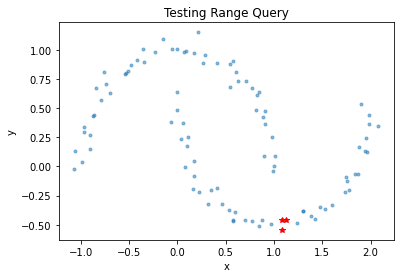

In [4]:
# Test it out
df_n = range_query( df_dbscan, 0, 0.1 )
plt.plot( df_dbscan['x'], df_dbscan['y'], '.', alpha = 0.5 )
plt.plot( df_n['x'], df_n['y'], 'r*')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Testing Range Query')
plt.show()

## Q2.3 Write a function to implement DBSCAN

Using the [pseudo-code](https://en.wikipedia.org/wiki/DBSCAN#Algorithm) on wikipedia, implement DBSCAN. This algorithm uses set notation, I found a handy summary on-line [here](http://www.math.cmu.edu/~bkell/21110-2010s/sets.html) if you need a refresher. 

```
DBSCAN(DB, distFunc, eps, minPts) {
    C := 0                                                  /* Cluster counter */
    for each point P in database DB {
        if label(P) ≠ undefined then continue               /* Previously processed in inner loop */
        Neighbors N := RangeQuery(DB, distFunc, P, eps)     /* Find neighbors */
        if |N| < minPts then {                              /* Density check */
            label(P) := Noise                               /* Label as Noise */
            continue
        }
        C := C + 1                                          /* next cluster label */
        label(P) := C                                       /* Label initial point */
        SeedSet S := N \ {P}                                /* Neighbors to expand */
        for each point Q in S {                             /* Process every seed point Q */
            if label(Q) = Noise then label(Q) := C          /* Change Noise to border point */
            if label(Q) ≠ undefined then continue           /* Previously processed (e.g., border point) */
            label(Q) := C                                   /* Label neighbor */
            Neighbors N := RangeQuery(DB, distFunc, Q, eps) /* Find neighbors */
            if |N| ≥ minPts then {                          /* Density check (if Q is a core point) */
                S := S ∪ N                                  /* Add new neighbors to seed set */
            }
        }
    }
}
```

The function should accept as parameters "DB", a data frame of points to be clustered, `df_data`, no distance function (assuming Euclidean distance), a floating point `eps` that defines the radius, and an integer `minPts`.  The function will return a series of cluster assignments of the same length as `df_data`. If the data is classified as noise, the cluster assignment is $0$, and all of the clusters will have a label of $1-k$, were $k$ is derived in the function and represents the total number of clusters found. 

Don't forget that [iterrows](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iterrows.html) is a lovely way to loop through a data frame. But if you modify the dataframe within the loop, it doesn't add more iterations to the loop.  For example, if you start with a dataframe of length $n$ and add $3$ rows, then the `iterrows` will stop after $n$ rows. For the inside loop, you'll need to use a native python list to dynamically grow the `SeedSet S`.  You can use the `extend` function to merge 2 lists together. For example:

```
x = [1,2,3]
y = [4,5,6]
x.extend(y) # sets x to the list [1, 2, 3, 4, 5, 6]
```

If you haven't used the [continue](https://docs.python.org/3/tutorial/controlflow.html) statement before, it can be useful in these situations, check out the link. 

Call `dbscan` with the `df_dbscan` data frame, `eps` set to 0.23, and `min_pts` set to 6 and save the results to `s_cluster_assignments` 

In [5]:
def dbscan( df_data, eps, min_pts ):
    NOISE_LABEL = 0
    cluster = 0
    labels = [float("inf") for i in range(len(df_data))]

    for idx, vals in df_data.iterrows():
      if not np.isinf(labels[idx]): 
        continue
      df_N = range_query(df_data, idx, eps)
      if len(df_N) < min_pts:
        labels[idx] = NOISE_LABEL
        continue
      else:
        cluster += 1
      labels[idx] = cluster
      df_N.drop(idx, inplace=True)
      N_idx = list(df_N.index)
      for idx2 in N_idx:
        if labels[idx2] == 0:
          labels[idx2] = cluster
        elif not np.isinf(labels[idx2]):
          continue
        labels[idx2] = cluster
        df_N = range_query(df_data, idx2, eps)
        if len(df_N) >= min_pts:
          N_idx.extend(list(df_N.index))
    labels = list(map(lambda x: -1*x + 1 if x > 1 else x, labels))
    return pd.Series(labels)

In [6]:
# Test it out
s_cluster_assignment = dbscan( df_dbscan, 0.23, 6)
s_cluster_assignment.value_counts()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


 1    49
-1    48
 0     3
dtype: int64

## Q2.4 Plot the Results 

Plot the points in the `df_dbscan` data frame using a 2-D scatter plot, with a different color for each cluster.  Use the cluster assignments from the previous problem (`s_cluster_assignments`). Label your axes, and give the plot a title.

Text(0, 0.5, 'y')

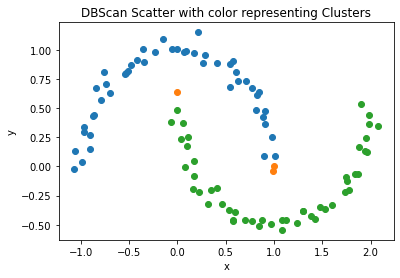

In [7]:
for label in np.unique(s_cluster_assignment):
    plt.scatter(df_dbscan["x"][s_cluster_assignment == label], df_dbscan["y"][s_cluster_assignment == label])
plt.title("DBScan Scatter with color representing Clusters")
plt.xlabel("x")
plt.ylabel("y")

## Q2.5 Compare your results to the scikit-learn library

Import DBSCAN from scikit-learn and compare the cluster labels from your implementation to the cluster labels generated from [scikit-learn's DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). Add some commentary about how you think the results compare. Use the same data and values for eps and minPts.

Text(0, 0.5, 'y')

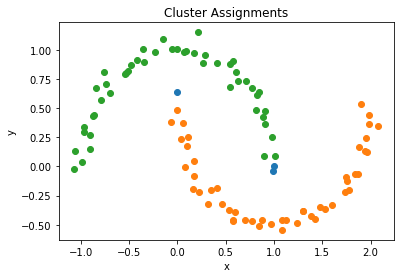

In [8]:
from sklearn.cluster import DBSCAN
model = DBSCAN(eps=0.23, min_samples=6)
model.fit(df_dbscan)
pd.Series(model.labels_).value_counts()

for label in np.unique(model.labels_):
    plt.scatter(df_dbscan["x"][model.labels_ == label], df_dbscan["y"][model.labels_ == label])
plt.title("Cluster Assignments")
plt.xlabel("x")
plt.ylabel("y")

Scikit seems to group better than our implementation with some outliers.